2024-2 언어데이터과학 기말프로젝트

# AI Hub 한국어-영어 번역 말뭉치를 통한 한국어 피동문과 영어 수동문의 생산성 분석

2021-14058 이예은

## 2 연구 방법

### 2.1 코퍼스

[[AI Hub]] [한국어-영어 번역(병렬) 말뭉치]는 AI 번역 엔진 개발을 위해 구성된 데이터로, 문어체 한영 번역 110만 문장과 구어체 한영 번역 50만 문장으로 이루어져 있다. 데이터는 '뉴스, 정부 웹사이트/저널, 법률, 한국문화, 구어체, 대화체' 등 총 6개 주제로 구분되며, 각각 xlsx 파일 형식으로 제공된다. 이 중 대화체 데이터(약 10만 문장, 9MB)를 다운로드하여 분석에 활용하였다. 

### 2.2 데이터 전처리
pandas를 사용해서 xlsx 파일을 데이터프레임으로 변환하고, 결측치를 제거한 다음 '대분류, 소분류, 상황, Set Nr, 발화자, 원문, 번역문' 열 중 필요한 정보인 '원문', '번역문'만 남겼다.

In [3]:
# 설치 필요 라이브러리
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install -U konlpy
!pip install jamo

# 필요한 라이브러리 임포트
import pandas as pd
from tqdm import tqdm
import re
import spacy
from spacy.matcher import Matcher
from konlpy.tag import Kkma
from jamo import h2j, j2hcj
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# 파일 경로 지정 및 데이터 읽기
file_path = '../data/한국어-영어 번역(병렬) 말뭉치/2_conversation_200226.xlsx'
df = pd.read_excel(file_path)

# 데이터 구조 및 샘플 확인
print(df.info())  # 데이터 구조 및 열 정보 확인
print(df.head())  # 첫 몇 행 출력

# 데이터 전처리: 결측치 제거 및 필요한 열 선택
df = df.dropna()  # 결측치 제거
df = df[['원문', '번역문']]  # 필요한 열만 선택

# 전처리된 데이터 출력
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   대분류      100000 non-null  object
 1   소분류      100000 non-null  object
 2   상황       100000 non-null  object
 3   Set Nr.  100000 non-null  int64 
 4   발화자      100000 non-null  object
 5   원문       100000 non-null  object
 6   번역문      100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
    대분류 소분류       상황  Set Nr.  발화자                            원문  \
0  비즈니스  회의  의견 교환하기        1  A-1   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1  비즈니스  회의  의견 교환하기        1  B-1    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2  비즈니스  회의  의견 교환하기        1  A-2  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   
3  비즈니스  회의  의견 교환하기        1  B-2   네, 제가 연락해서 주문량을 2배로 늘리겠습니다.   
4  비즈니스  회의  의견 교환하기        2  A-1   지난 회의 마지막에 논의했던 안건을 다시 볼까요?   

                                                 번역문  
0  How is the market's reactio

,원문,번역문
0,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...
...,...,...
99995,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


### 2.3 데이터 가공
전체 데이터에서 영어 수동문을 감지한 뒤, 수동문이 포함된 데이터만 필터링하여 해당 범위 내에서 대응하는 한국어 원문의 피동 표현을 분석했다.
### 2.3.1 영어 데이터 가공 - 영어 수동문 감지
영어 수동문 감지는 [Stack Overflow 솔루션](https://stackoverflow.com/questions/74528441/detect-passive-or-active-sentence-from-text)을 참고하여 spaCy 라이브러리의 Matcher 클래스를 활용해 구현했다.

In [12]:
# spaCy 모델 로드
nlp = spacy.load("en_core_web_sm")

# 수동문 감지 패턴 정의
'''
nsubjpass: nominal subject (passive)
aux: auxiliary
auxpass: auxiliary (passive)
VBN: verb, past participle
VBZ: verb, 3rd person singular present
RB: adverb 
''' 

matcher = Matcher(nlp.vocab)
passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}], 
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]
matcher.add("Passive", passive_rules)

# 수동문 개수 계산 함수
def count_passive_sentences(text):
    doc = nlp(text)  # 텍스트 처리
    matches = matcher(doc)  # Matcher로 패턴 매칭
    return len(matches)  # 매칭된 패턴 개수 반환

In [13]:
# 각 영어 문장에 대해 수동문 개수 계산
eng_passive_counts = []
for text in tqdm(df['번역문'], desc="Processing Sentences"):
    count = count_passive_sentences(text)
    eng_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["eng_passive_count"] = eng_passive_counts
df = df[df["eng_passive_count"] > 0].reset_index(drop=True) # 영어 수동문 기준 데이터 필터링

Processing Sentences: 100%|██████████| 100000/100000 [07:14<00:00, 229.99it/s]


### 2.3.2 한국어 데이터 가공 - 한국어 피동문 감지
이후 필터링된 6,467개의 병렬 데이터를 대상으로 한국어 원문의 피동 표현을 감지하고 개수를 계산했다. 피동 표현 감지에는 koNLPy의 Kkma 클래스와 jamo 라이브러리를 활용했으며, 다음과 같은 세 가지 유형으로 피동 표현을 분류했다.

1) 피동 접미사 "-이/히/리/기-"를 포함한 패턴
* 이 때 동사 어근 자체에 "이/히/리/기"가 포함되어 오류가 발생하는 것을 방지하기 위해 "드리다", "모이다"와 같은 예외를 설정했다.
2) 보조동사 "-어지다"를 포함한 패턴
* 이 때 자모 분석을 통해 'ㅡ' 탈락과 어간 말 모음 'ㅏ, ㅓ, ㅐ, ㅔ' 뒤에서 연결 어미 "어/아"가 탈락하는 환경에서도 피동 표현을 감지하도록 설정했다. (예: 보내+(어)+지+다 --> 보내지다, 끄+(어)+지+다 --> 꺼지다)
3) 피동 접미사 "-되다", "-받다", "-당하다"를 포함한 패턴 
* 이 때 해당 표현이 접미사가 아닌 동사로 쓰이는 경우는 띄어쓰기 여부를 기준으로 필터링하여 제외했다.

In [20]:
# 형태소 분석기 로드
kkma = Kkma()

# 한국어 피동문 유형별 패턴 감지 함수
def count_korean_passive_sentences(text):
    tokens = kkma.pos(text)  # 형태소 분석
    
    # 각 피동 탐지 조건별 결과 저장
    detected_patterns = {
        "passive_suffix": [],
        "passive_auxiliary": [],
        "passive_verb": []
    }
    # 1. 피동 접미사 "-이/히/리/기-" 패턴 탐지
    # '드리다'와 같이 동사 어근에 '리'가 포함되어 잘못 감지되는 경우를 제외
    for tok in tokens:
        if tok[1] == 'VV' and tok[0].endswith(('이', '히', '리', '기')) and tok[0] not in {'드리', '모이'}: 
            detected_patterns["passive_suffix"].append(tok)

     # 2. 보조동사 "-어지다" 패턴 탐지
     # 자모 분석을 통해 모음 탈락 조건에서 연결 어미 "어/아"가 생략되는 경우 포함
    for i in range(len(tokens) - 2):
        if (tokens[i][1] == 'VV' and 
        ((tokens[i+1][0] in {'어', '아'} and tokens[i+2][0] == '지') or
        (any(vowel in j2hcj(h2j(tokens[i][0][-1])) for vowel in {'ㅓ', 'ㅏ', 'ㅐ', 'ㅔ', 'ㅡ'}) and 
        tokens[i+1][0] == '지'))):
            detected_patterns["passive_auxiliary"].append((tokens[i], tokens[i+1], tokens[i+2]))

    # "-되다", "-받다", "-당하다" 패턴 탐지
    # 해당 표현이 접미사가 아닌 동사로 쓰이는 경우 제외 (띄어쓰기 여부를 기준으로 필터링)
    for tok in tokens:
        if tok[1] == 'VV' and re.search(r'^\s*받|^(되|당하)', tok[0]): 
            detected_patterns["passive_verb"].append(tok)
    
    # 총 탐지 개수 반환
    total_count = sum(len(matches) for matches in detected_patterns.values())
    return total_count

In [21]:
# 각 한국어 문장에 대해 수동문 개수 계산
kor_passive_counts = []
for text in tqdm(df['원문'], desc="Processing Sentences"):
    count = count_korean_passive_sentences(text)
    kor_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["kor_passive_count"] = kor_passive_counts
df = df[['원문', '번역문', 'kor_passive_count', 'eng_passive_count']]

Processing Sentences: 100%|██████████| 6467/6467 [01:39<00:00, 64.69it/s] 


In [23]:
pd.options.display.max_colwidth = 1000
df

,원문,번역문,kor_passive_count,eng_passive_count
0,우리 제품은 어떤 방식으로 도쿄에 보내지나요?,How will our products be shipped to Tokyo?,1,1
1,먼저 배로 도쿄 근처 항구까지 운반하고 그 후 차를 이용합니다.,"They'll be sent to Tokyo port by the ship, then transported by vehicles.",0,1
2,교육 안내 메일 하단에 작은 글씨로 적혀있어요.,It was written in very small letters at the bottom of the notification email.,1,1
3,7월 29일부터 8월 2일까지가 공식적인 기간이에요.,It's officially scheduled from July 29 to August 2.,0,1
4,"네, 메일로 이미 공지를 했으니 다들 알고 있을 거에요.","Sure, but they'd already known since it was notified by email earlier.",0,1
...,...,...,...,...
6462,"저희가 디저트 판매대를 신설해서요, 케이크 매장은 거기로 옮겨갔어요.","We have newly installed a dessert stand, the cake shop was moved there.",0,1
6463,"저희도 정확한 날짜는 몰라서요, 이번 달 안에는 나오지 않을까요?","We don't know the exact date either, wouldn't it be released this month?",0,1
6464,"이 패턴이 맘에 드는데, 다른 색상 좀 보여주세요.","We don't know the exact date either, wouldn't it be released this month?",0,1
6465,"저는 이렇게 주머니가 많은 게 좋던데, 요즘 나오는 가방들은 주머니가 없더라고요.","I like having many pockets like this, but bags that are sold nowadays don't have pockets.",0,1


## 3. 연구 결과
### 3.1 현상 기술
영어 수동문을 기준으로 필터링한 6,467개의 데이터에서 감지된 영어 수동문과 한국어 피동 표현의 개수는 다음과 같다.

/tmp/ipykernel_17537/2168491970.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")


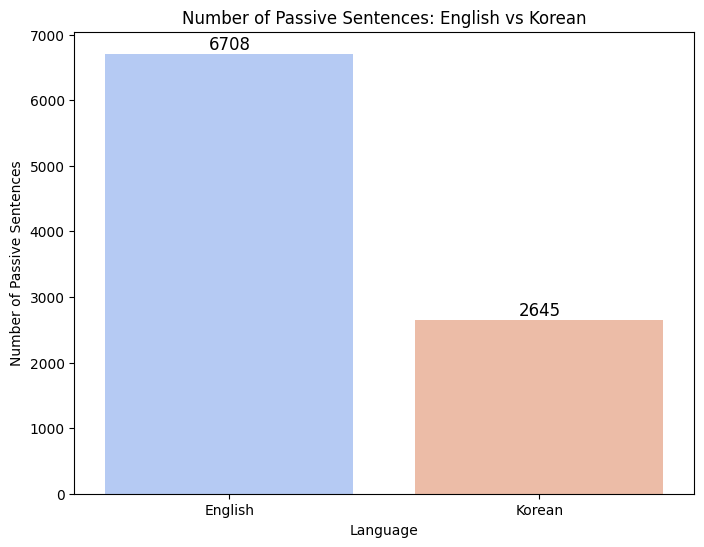

In [24]:
# 원문과 번역문 별 수동문 합계 계산 및 시각화
df_summary = df.melt(id_vars=["원문", "번역문"], 
                     value_vars=["eng_passive_count", "kor_passive_count"]) \
               .groupby("variable").sum().reset_index()
# 그래프 시각화
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")

# 각 바 위에 수동문 개수 표시
for i, v in enumerate(df_summary["value"]):
    ax.text(i, v + 10, f"{v}", ha="center", va="bottom", fontsize=12)

#그래프 제목 및 라벨 설정
plt.title("Number of Passive Sentences: English vs Korean")
plt.ylabel("Number of Passive Sentences")
plt.xlabel("Language")
plt.xticks([0, 1], ["English", "Korean"])

plt.show()

다음으로, 영어 수동문과 한국어 원문의 번역 관계를 피동 표현 개수를 기준으로 시각화하여 분석했다.

/tmp/ipykernel_17537/787704757.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=analysis_counts.index, y=analysis_counts.values, palette="viridis")
/tmp/ipykernel_17537/787704757.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)


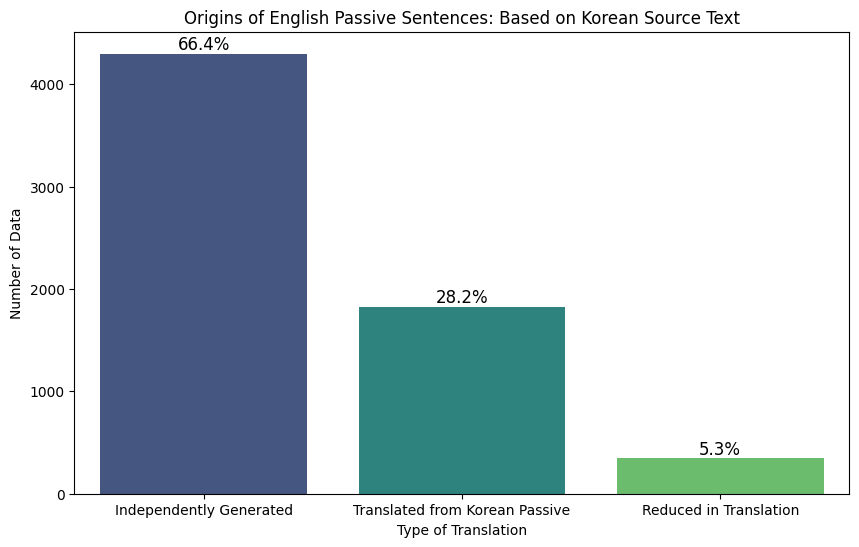

In [25]:
# 범주화: 줄어듦, 유지됨, 증가됨
def determine_passive_generation(row):
    if row["eng_passive_count"] > row["kor_passive_count"]:
        return "independently generated"  # 독자적으로 생성된 경우
    elif row["eng_passive_count"] == row["kor_passive_count"]:
        return "translated from Korean passive"  # 한국어 피동에서 번역된 경우
    else:
        return "reduced in English translation"  # 한국어 피동 표현이 능동으로 전환된 경우

df["passive_analysis"] = df.apply(determine_passive_generation, axis=1)

# 각 범주의 개수 계산
analysis_counts = df["passive_analysis"].value_counts()

# 퍼센트 계산
total = analysis_counts.sum()
percentages = (analysis_counts / total) * 100

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=analysis_counts.index, y=analysis_counts.values, palette="viridis")

for i, count in enumerate(analysis_counts.values):
    plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title("Origins of English Passive Sentences: Based on Korean Source Text")
plt.xlabel("Type of Translation")
plt.ylabel("Number of Data")
plt.xticks([0, 1, 2], ["Independently Generated", "Translated from Korean Passive", "Reduced in Translation"])
plt.show()